In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.4.1
0.12.1


# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

## Class work - Bijectors

In [4]:
z = tf.constant([1.,2.,3.])
scale = tfb.Scale(2.)
x = scale.forward(z)
print(x)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)


In [5]:
scale.inverse(tf.constant([5.,3.,1.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.5, 1.5, 0.5], dtype=float32)>

In [7]:
scale = tfb.Scale(2.)
shift = tfb.Shift(1.)
scale_and_shift = tfb.Chain([shift, scale]) #Applied in reverse order

In [8]:
scale_and_shift.forward(z)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 5., 7.], dtype=float32)>

In [9]:
scale_and_shift.inverse(z)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0. , 0.5, 1. ], dtype=float32)>

In [11]:
scale = tfb.Scale(2.)
shift = tfb.Shift(1.)
scale_and_shift = shift(scale) # tfb.Chain([shift, scale])
scale_and_shift.inverse(tf.constant([2.,5.,8.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 2. , 3.5], dtype=float32)>

In [12]:
scale_and_shift(z) # scale_and_shift.forward(z)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 5., 7.], dtype=float32)>

In [14]:
normal = tfd.Normal(loc=0.,scale=1.)
z = normal.sample(3)
print(z)

tf.Tensor([-0.44481495 -1.70659    -0.36715233], shape=(3,), dtype=float32)


In [15]:
scale_and_shift = tfb.Chain([tfb.Shift(1.),tfb.Scale(2.)])
print(scale_and_shift.forward(z))

tf.Tensor([ 0.1103701  -2.41318     0.26569533], shape=(3,), dtype=float32)


In [17]:
log_prob_z = normal.log_prob(z)
print(log_prob_z)

tf.Tensor([-1.0178686 -2.3751633 -0.9863389], shape=(3,), dtype=float32)


In [19]:
# acc to the change of variables formula
# event n dims is 0 because z has event shape 0
log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z,event_ndims=0)
print(log_prob_x)

tf.Tensor([-1.7110158 -3.0683105 -1.679486 ], shape=(3,), dtype=float32)


In [21]:
bijector = tfb.Chain([tfb.Scale(3.), tfb.Shift(-1.), tfb.Scale(2.)])
z = tf.constant([1., 0.])
x = bijector(z)
print(x)

tf.Tensor([ 3. -3.], shape=(2,), dtype=float32)


***
<a id="coding_tutorial_1"></a>
## Bijectors

In [22]:
# Define base distribution
normal = tfd.Normal(loc=0., scale=1.)


In [23]:
# Sample from base distribution
n=10000
z=normal.sample(n)

### Scale and shift bijector

In [24]:
# Define scale and shift
scale = 4.5
shift = 7


In [25]:
# Define chain bijector
scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])


In [26]:
# We can also use call methods

scale_transf = tfb.Scale(scale)
shift_transf = tfb.Shift(shift)
scale_and_shift = shift_transf(scale_transf)

In [27]:
# Apply the forward transformation
x = scale_and_shift.forward(z)


In [28]:
# Check the forward transformation

tf.norm(x-(scale*z+shift))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Plots

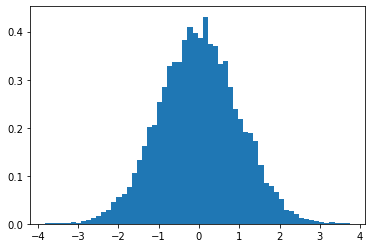

In [29]:
# Plot z density

plt.hist(z, bins=60,density=True)
plt.show()

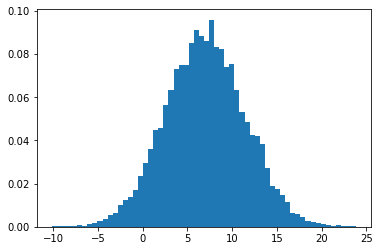

In [30]:
# Plot x density

plt.hist(x,bins=60, density=True)
plt.show()

#### Inverse transformation

In [31]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(x)

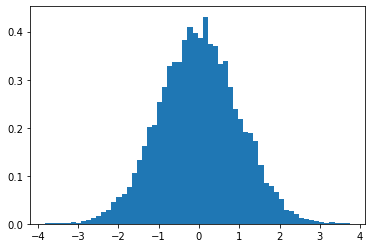

In [43]:
plt.hist(inv_x,bins=60, density=True)
plt.show()

In [32]:
# Check inverse transformation

tf.norm(inv_x - z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Log probability

In [33]:
# Compute log prob for x

log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z, event_ndims=0)
print(log_prob_x)

tf.Tensor([-2.4292493 -2.5004623 -2.6403189 ... -2.6021104 -2.8086007 -2.7260888], shape=(10000,), dtype=float32)


In [34]:
# We can also use the inverse transformation

lob_prob_x = (normal.log_prob(scale_and_shift.inverse(x))
                             + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0))
print(lob_prob_x)

tf.Tensor([-2.4292493 -2.5004623 -2.6403189 ... -2.6021104 -2.8086007 -2.7260888], shape=(10000,), dtype=float32)


### Broadcasting

In [35]:
x = tf.random.normal(shape=(100, 1))

In [36]:
# Softfloor bijector
softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)


(100, 1)


In [37]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.2,1.])
y = softfloor.forward(x)
print(y.shape)

(100, 2)


In [38]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.2,1.,1.])

In [39]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

In [40]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]

In [41]:
# Gumbel bijector using broadcasting
exps = tfb.GumbelCDF(loc=[0.5,1,1.5,2,3], scale=[1,2,2,3,4])


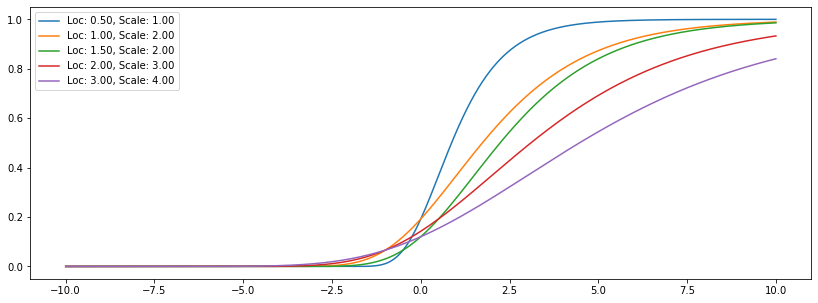

In [42]:
# Plot
x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5,exps,['loc','scale'],x)

## The TransformedDistribution class Classwork

In [44]:
normal = tfd.Normal(loc=0.,scale=1.)
z = normal.sample(3)
print(z)

tf.Tensor([ 0.4548124   0.37241927 -0.15413916], shape=(3,), dtype=float32)


In [45]:
scale_and_shift = tfb.Chain([tfb.Shift(1.),tfb.Scale(2.)])
x = scale_and_shift.forward(z)

In [48]:
log_prob_z = normal.log_prob(z)
log_prob_x = (normal.log_prob(z) - 
             scale_and_shift.forward_log_det_jacobian(z,event_ndims=0))
# here we are calculating the log prob of x using the tensor z
print(log_prob_x)

tf.Tensor([-1.7155129 -1.6814337 -1.6239651], shape=(3,), dtype=float32)


In [ ]:
# Inverse using change of variable formula
# here we are calculating the log prob of x using only the tensor x
log_prob_x = (normal.log_prob(scale_and_shift.inverse(x)) + 
             scale_and_shift.inverse_log_det_jacobian(x,event_ndims=0))
print(log_prob_x)

In [ ]:
# Normalising flow is a generative model of the data
# Model assumes:
# Base dist        Tramnsformation         Data Dist
# z~P0              x = f(z)                x~P1
# Latent variable z is distributed acc to some base dist like a Gaussian
# Data generating process first samples z and then transforms it using function f top produce data sample x
# function f is bijectible and it will be parametrized and learn the parameters with max likelihood
# IN the training process we will have x and will want to calculate log prob under the model
# this log prob will be maximized within a training loop. The bijector object contains the parameters to optimize

log_prob_x = (base_dist.log_prob(bijector.inverse(x))
             + bijector.inverse_log_det_jacobian(x,event_ndims=0))

#once the mode is trained
x_sample = bijector.forward(base_dist.sample())

In [52]:
# Simple example
normal = tfd.Normal(loc=0., scale=1.) #Base dist
z=normal.sample(3)

#exponential bijector
exp = tfb.Exp()
x = exp.forward(z) # Sample from base dist z and pass the sample through the bijector

# TransformedDistribution is useful to directly define the distribution objection P1 with the data dist object
# 
log_normal=tfd.TransformedDistribution(normal, exp)
print(log_normal)

tfp.distributions.TransformedDistribution("expNormal", batch_shape=[], event_shape=[], dtype=float32)


In [54]:
log_normal = exp(normal) # Same as explicitly creating the TransformedDistribution
log_normal

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

In [55]:
print(log_normal.sample()) # first sampling from base dist and then passing it through the bijector
print(log_normal.log_prob(x)) # change of variables formula is being applied.

tf.Tensor(0.84951, shape=(), dtype=float32)
tf.Tensor([-1.0299513 -0.5292157 -2.632886 ], shape=(3,), dtype=float32)


In [56]:
normal = tfd.Normal(loc=0.,scale=1.)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [59]:
scale_tril = [[1.,0.],[1.,1.]] # (2,2)
scale = tfb.ScaleMatvecTriL(scale_tril=scale_tril)
print(scale)

In [66]:
mvn = tfd.TransformedDistribution(normal, scale)
mvn

<tfp.distributions.TransformedDistribution 'scale_matvec_trilNormal' batch_shape=[] event_shape=[] dtype=float32>

In [69]:
normal = tfd.Normal(loc=0., scale=[1., 1.])
print(normal)
scale = tfb.Scale([1., 2.])
mvn = tfd.TransformedDistribution(normal, scale)
print(mvn)

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
tfp.distributions.TransformedDistribution("scaleNormal", batch_shape=[2], event_shape=[], dtype=float32)


***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [70]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [71]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [72]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [73]:
# Exponential bijector
exp = tfb.Exp()


In [74]:
# Log normal transformed distribution using exp and normal bijectors
log_normal_td = exp(normal)


In [75]:
# Display event and batch shape
print('batch shape: ', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)


batch shape:  ()
event shape:  ()


In [76]:
# Base distribution

z = normal.sample(n)

#### Plots

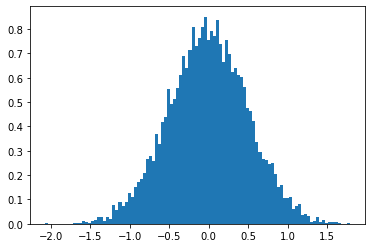

In [77]:
# Plot z density
plt.hist(z, bins=100, density=True)
plt.show()

In [79]:
# Transformed distribution

x = log_normal_td.sample(n)

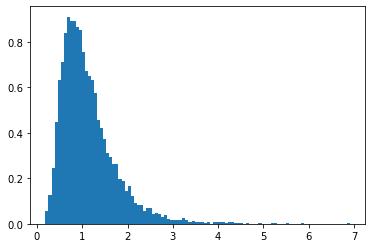

In [80]:
# Plot x density

plt.hist(x, bins=100, density=True)
plt.show()

In [81]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc,scale=scale)

In [83]:
# Sample log_normal
l = log_normal.sample(n)


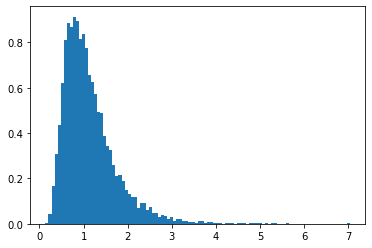

In [85]:
# Plot l density
plt.hist(l, bins=100, density=True)
plt.show()



#### Log probability

In [86]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [87]:
# Log prob of log normal transformed distribution
log_prob_td = log_normal_td.log_prob(x)


In [88]:
# Check log probs
tf.norm(log_prob - log_prob_td)


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Event shape and batch shape

In [89]:
# Set a scaling lower triangular matrix

tril = tf.random.normal((2,4,4))
scale_low_tril = tf.linalg.LinearOperatorLowerTriangular(tril)

In [91]:
# View of scale_low_tri
scale_low_tril.to_dense()


<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.7166592 ,  0.        ,  0.        ,  0.        ],
        [-0.2922111 ,  1.5233504 ,  0.        ,  0.        ],
        [ 0.3466504 ,  0.766438  ,  1.739828  ,  0.        ],
        [-0.0619625 , -0.30540714,  0.35454577, -1.1598246 ]],

       [[ 1.0948175 ,  0.        ,  0.        ,  0.        ],
        [ 1.3781855 , -0.22650315,  0.        ,  0.        ],
        [ 0.24898072,  1.0838823 , -1.422643  ,  0.        ],
        [-1.2667339 ,  0.6058173 , -0.05413007,  0.6836213 ]]],
      dtype=float32)>

In [92]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tril)

In [95]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution(normal, scale_lin_op, parameter_properties=2)
mvn

TypeError: __init__() got an unexpected keyword argument 'parameter_properties'

In [ ]:
# Display event and batch shape



In [ ]:
# Sample



In [ ]:
# Define a MultivariateNormalLinearOperator distribution



In [ ]:
# Display event and batch shape



In [ ]:
# Sample



In [ ]:
# Check



## Subclassing bijectors Classword

In [97]:
class MySigmoid(tfb.Bijector):
    
    def __init__(self,validate_args=False, name='sigmoid'):
        super(MySigmoid, self).__init__(
        validate_args=validate_args, forward_min_event_ndims=0, name=name, is_constant_jacobian=True)
    
    def _forward(self,x):
        return tf.math.sigmoid(x)
    
    def _inverse(self, y):
        return tf.math.log(y) - tf.math.log(1-y)
    
    def _inverse_log_det_jacobian(self, y):
        return -tf.math.log(y) - tf.math.log(1-y)
    
    def _forward_log_det_jacobian(self, x):
        return -tf.math.softplus(-x) - tf.math.softplus(x)
    #OR return -self._inverse_log_det_jacobian(self._forward(x))

In [106]:
x = tf.constant([2.])
y = MySigmoid(x)

In [107]:
print(y)

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [111]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self,x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a*x + self.b,3))

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y),1/3) - self.b) / self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x,tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x +self.b))

In [112]:
# Cubic bijector

cubic = Cubic([1.0,-2.0],[-1.,0.4], validate_args=True)

In [130]:
# Apply forward transformation

x = tf.constant([[1,2],[3,4]])
print(x.shape)
y = cubic.forward(x)
print(y)
print(y.shape)

(2, 2)
tf.Tensor(
[[   0.        -46.655994]
 [   8.       -438.97598 ]], shape=(2, 2), dtype=float32)
(2, 2)


In [114]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

#### Function plots

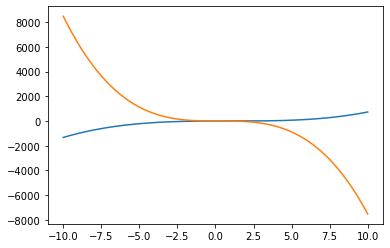

In [116]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x,cubic.forward(x))

In [117]:
# Display shape
print(cubic.forward(x).shape)


(500, 2)


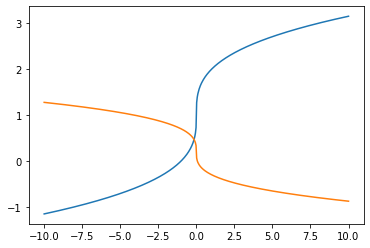

In [118]:
# Plot the inverse
plt.plot(x, cubic.inverse(x))


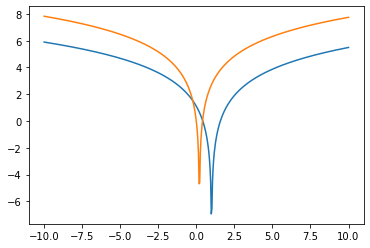

In [121]:
# Plot the forward log Jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x,event_ndims=0))

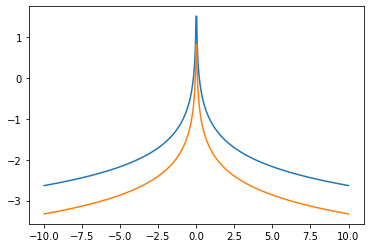

In [123]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x,event_ndims=0))

#### TransformedDistribution and plots

In [167]:
# Create a transformed distribution with Cubic

normal = tfd.Normal(loc=[0., 0.], scale=[1., 1.])
ind = tfd.Independent(
    distribution=normal,
    reinterpreted_batch_ndims=1)
print(normal, ind)
cubed_normal = tfd.TransformedDistribution(ind, cubic)
print(cubed_normal)

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32) tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[2], dtype=float32)
tfp.distributions.TransformedDistribution("CubicIndependentNormal", batch_shape=[], event_shape=[2], dtype=float32)


In [169]:
# Sample cubed_normal

n = 1000
g = cubed_normal.sample(n)
print(g.shape)
print(g)

(1000, 2)
tf.Tensor(
[[-2.22409582e+00  4.89441605e+01]
 [-3.01679230e+01  1.10084975e-05]
 [-6.62671041e+00 -1.12513504e+01]
 ...
 [-6.46692574e-01  2.43614330e+01]
 [-6.36968279e+00  3.25361023e+01]
 [-1.29153621e+00 -3.27568436e+00]], shape=(1000, 2), dtype=float32)


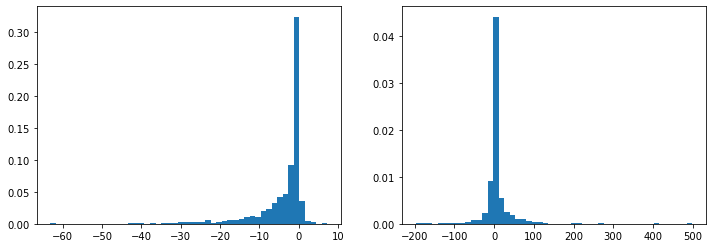

In [170]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

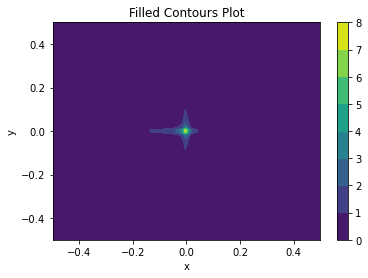

In [171]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [173]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(normal)


In [174]:
# Samble inv_cubed_normal
n = 1000
g = inv_cubed_normal.sample(n)
g.shape


TensorShape([1000, 2])

TypeError: Input z must be 2D, not 3D

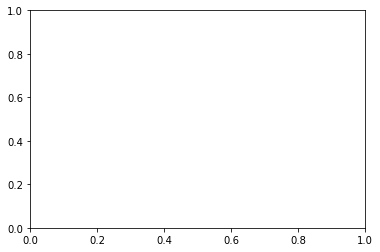

In [175]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [ ]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

#### Training the bijector

In [141]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(
            cat=tfd.Categorical(probs=probs),
    components=[tfd.Normal(loc=2.3, scale=0.4),
               tfd.Normal(loc=-0.8, scale=0.4)]
)

In [142]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


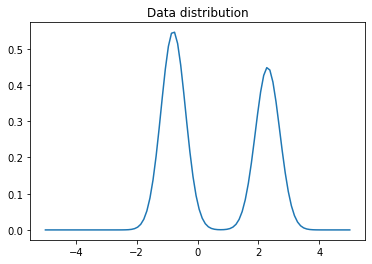

In [144]:
# Plot the data distribution

x = np.linspace(-5.0, 5.0, 100)
plt.plot(x,mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()

In [145]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [146]:
# Make a trainable transformed distribution
trainable_dist = tfd.TransformedDistribution(normal,trainable_inv_cubic)


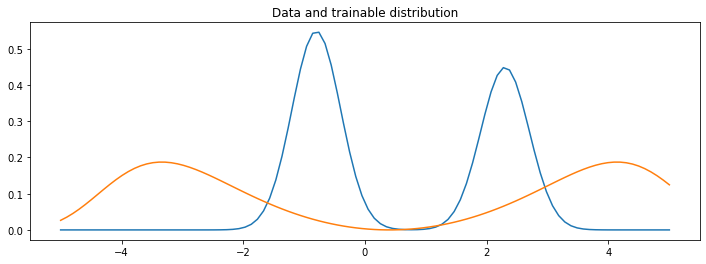

In [148]:
# Plot the data and learned distributions
x = np.linspace(-5.0,5.0,100)

plt.figure(figsize=(12,4))
plt.plot(x,mix_gauss.prob(x), label='data')
plt.plot(x,trainable_dist.prob(x), label='trainable')
plt.title('Data and trainable distribution')
plt.show()


In [149]:
# Train the bijector

num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


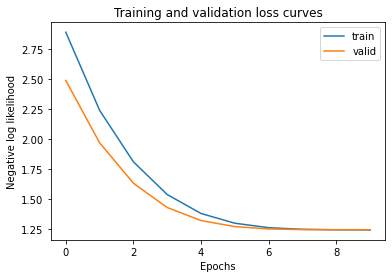

In [150]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

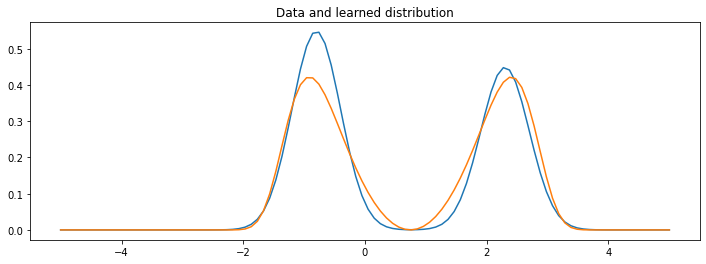

In [151]:
# Plot the data and learned distributions
plt.figure(figsize=(12,4))
plt.plot(x,mix_gauss.prob(x), label='data')
plt.plot(x,trainable_dist.prob(x), label='learned')
plt.title('Data and learned distribution')
plt.show()


In [152]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5634147>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.42040256>)

## Autoregressive flows Classwork

In [178]:
# z ~ N(0, I)
# x[i] = z[i] * scale(x[0:i-1])+ loc(x:i-1]), i=0,...,D-1         This is the autoregressive flow
# Autoregressive property. Data X is D dimensional and features are indexed by i
# The joint distribution of all features is given above. This is the masked auto regressive flow.
# Jacobian matrix is lower triangular hence determinant is easy to compute

made = tfb.AutoregressiveNetwork( params=2, event_shape=[3], hidden_units=[16,16], activation='sigmoid')
made(tf.random.normal([2,3]))
# The last 2 in the dimension in the result is from params.
# This network is designed to respect the autoregressive property
# that means each parameter of each feature i is computed only using the features upto i-1
# it does this by zeroing out number of weights in the network

<tf.Tensor: shape=(2, 3, 2), dtype=float32, numpy=
array([[[ 0.        ,  0.        ],
        [-0.6732211 ,  0.255152  ],
        [-0.15803315,  0.7661412 ]],

       [[ 0.        ,  0.        ],
        [-0.7065327 ,  0.27843645],
        [-0.11029163,  0.7624563 ]]], dtype=float32)>

In [ ]:
# the maf_bijector is used to shift and scale the random parameter zi output by the made network
maf_bijector = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
# Pseudo code only
def forward(z):
    x = tf.zeros_like(z)
    for _ in range(D): # one time for each feature xi, the calculations are as per equation above
        shift,log_scale=shift_and_log_scale_fn(x)
        x=z*tf.math.exp(log_scale)+shift
    return x

def inverse(x):
    shift, log_scale = shift_and_log_scale(x)
    return (x-shift) / tf.math.exp(log_scale)

In [ ]:
normal=tfd.normal(loc=0,scale=1)
maf=tfd.transformedDistribution(normal,maf_bijector,event_shape=[3])# this invokes the forward transformation


In [ ]:
maf_bijector = tfb.MaskedAutoregressiveFlow(
                lambda y: (made(y)[...,0],None),
                is_constant_jacobian=True)
# This is as per modified equation: x[i] = z[i] + loc(x[0:i-1]), i=0,...,D-1
maf_bijector._made = made
#if you're implementing something like this, and that is that if we pass in a Python function
# to the shift and log scale function argument, like we're doing here with a Lambda function,
# then the masked autoregressive flow object isn't able to save a reference to all TensorFlow 
# variables used by that function. An easy solution to this is to reference the variables by 
# setting an attribute to the masked autoregressive flow object like this. Now, the bijector will 
# track all variables used by the MADE network
normal=tfd.normal(loc=0,scale=1)
maf=tfd.transformedDistribution(normal,maf_bijector,event_shape=[3])

## REal NVP Classwork

In [ ]:
# z ~ N(0, I)
# x[0:d] = z[0:d]
# x[d:D] = z[d: D] * scale(z[0:d]) + loc(z[0:d])      Affine coupling layer
# Real NVP is a special case of autoregressiveflows
# x is partitioned 0 to d to D
shift_and_log_scale_fn = tfb.real_nvp_default_template(
                            hidden_layers=[32,32],activation=tf.nn.relu)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [179]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

(-2.0, 2.0)

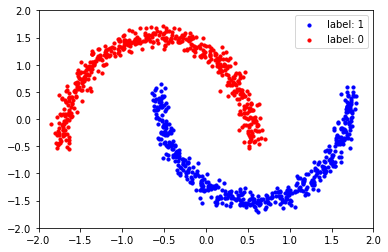

In [180]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [181]:
# Define base distribution

base_distribution = tfd.Normal(loc=0, scale=1)


In [182]:
# Define the trainable distribution

def make_masked_autoregressive_flow(hidden_units=[16,16], activation='relu'):
    # The autoregressive network
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution,
                                                    make_masked_autoregressive_flow(), event_shape=[2])


TypeError: __init__() got an unexpected keyword argument 'event_shape'

In [183]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [184]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

In [185]:
# Plot contour

activation = 'relu'
maf = tfd.TransformedDistribution(base_distribution,
                                 make_masked_autoregressive_flow(activation=activation),
                                 event_shape=[2])
plot_contour_prob([maf],scale_fig=6, title=[activation])


TypeError: __init__() got an unexpected keyword argument 'event_shape'

In [186]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [188]:
# Make samples

x = base_distribution.sample((1000,2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

NameError: name 'trainable_distribution' is not defined

In [ ]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

In [ ]:
# Plot

_plot(samples)

#### Training a MaskedAutoregressiveFlow bijector

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback

In [ ]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [ ]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)

In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples

x = base_distribution.sample((1000,2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

In [ ]:
# Plot

_plot(samples)

In [ ]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

In [ ]:
# Plot contour

plot_contour_prob([trainable_distribution], scale_fig=6)

#### Training a chain of MaskedAutoregressiveFlow bijectors

In [ ]:
# Define a more expressive model

num_bijectors=6
bijectors=[]
for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256,256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1,0]))

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1]))) #Discard last layer

In [ ]:
# Define the trainable distribution

trainable_distribution = tfd.TransformedDistribution(distribution=base_distribution,
                                                    bijector=flow_bijector,
                                                    event_shape=[2])


In [ ]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

In [ ]:
# Plot

_plot(samples,3)


In [ ]:
# Plot

visualize_training_data(samples)

In [ ]:
# Train the distribution

history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples and plot

names, samples = make_samples()

_plot(samples,3)


In [ ]:
# Plot

visualize_training_data(samples)

In [ ]:
# Plot

plot_contour_prob([trainable_distribution], scale_fig=6)